# 🚀 Classification Challenge: Passenger Transportation Analysis (30/100)

Welcome to MSC-AI Consulting! You are working with the Galactic Transportation Initiative (GTI), a client dedicated to safe and efficient passenger transport between planets. Your goal is to predict if a passenger will be transported based on various personal and travel attributes.

GTI has provided you with a preprocessing pipeline (`preprocessor`), which handles all the necessary transformations and encoding of features. Use this pipeline to focus on model comparison, evaluation, and optimization based on different error costs.



# 📄 Dataset Overview
Key features in the dataset include:

- `Age` and `VIP` status of passengers.
- Spending in areas such as `RoomService`, `FoodCourt`, `ShoppingMall`, `Spa`, and `VRDeck`.
- `Cabin` information, split into deck, number, and side.
- `HomePlanet` and `Destination`.
- `CryoSleep` status, which may affect passenger behavior during the journey.
- The **target** variable, `Transported`, indicates whether a passenger was successfully transported (TRUE/FALSE).



# Part A: Initial Model Comparison and Hyperparameter Tuning (12 points)

## Model Selection

Start by comparing two classification models, such as Logistic Regression and K-Nearest Neighbors (KNN). These models will serve as your baseline for understanding general performance on this dataset.

## Hyperparameter Tuning

Perform `RandomizedSearchCV` with 5-fold cross-validation (`cv=5`) to optimize each model. Use two hyperparameters for each model:
- For Logistic Regression, consider parameters such as `C` (regularization strength) and `solver`.
- For K-Nearest Neighbors, consider parameters like `n_neighbors` and `weights`.

Record the best parameters and use the optimized models for further evaluation.

## Performance Metrics

Evaluate both optimized models on the test set using accuracy, precision, recall, F1-score, and AUC-ROC.
Generate ROC-AUC curves for each model and plot them to visualize the trade-offs between true positive and false positive rates.

## Model Comparison

Based on all performance metrics, ROC-AUC, choose the winning model from this initial comparison and save it as `best_model`. 

# Part B: Error Analysis and Threshold Selection for Specific Scenarios (18 points)

Use the `best_model`, optimized model from Part A for threshold selection and error analysis, focusing on GTI’s two specific scenarios:

## Scenario 1: Both False Negatives (FN) and False Positives (FP) are costly

In this scenario, GTI wants a balanced approach that minimizes both FN and FP.
- **Goal**: Find a threshold that achieves a good balance between precision and recall.

## Scenario 2: False Negatives (FN) are more costly than False Positives (FP)

Here, GTI prioritizes minimizing False Negatives.
- **Goal**: Adjust the threshold to achieve higher recall, even if it increases FP.


# Documentation
After completing Part A and Part B, summarize your findings in a brief paragraph:

- For Part A: Explain your model selection and comparison process, highlighting why the chosen model performed best in terms of AUC-ROC. 
- For Part B: Document the thresholds chosen for each scenario, include any trade-offs you encountered when adjusting the threshold, especially in Scenario 2 where FN is prioritized.


In [97]:
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score, RocCurveDisplay, PrecisionRecallDisplay
import matplotlib.pyplot as plt


# Custom transformer for splitting 'Cabin' feature
class CabinSplitter(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        cabin_df = X['Cabin'].fillna('Unknown/0/Unknown').str.split('/', expand=True)
        cabin_df.columns = ['Cabin_Deck', 'Cabin_Num', 'Cabin_Side']
        return cabin_df

#preprocessing pipelines
numeric_features = ['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']
categorical_features = ['HomePlanet', 'CryoSleep', 'Destination', 'VIP']
cabin_feature = ['Cabin'] 

# Num pipeline
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

# Cat pipeline
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

# Cabin pipeline
cabin_transformer = Pipeline(steps=[
    ('cabin_split', CabinSplitter()),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

# Full preprocessor pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features),
        ('cabin', cabin_transformer, cabin_feature)
    ])

In [98]:
preprocessor

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('imputer', SimpleImputer()),
                                                 ('scaler', StandardScaler())]),
                                 ['Age', 'RoomService', 'FoodCourt',
                                  'ShoppingMall', 'Spa', 'VRDeck']),
                                ('cat',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('onehot',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False))]),
                                 ['HomePlanet', 'CryoSleep', 'Destination',
                                  'VIP']),
                                ('cabin',
                                 Pipeline(steps=[('cabin_split',
                                                  CabinSplitter()),
                                                 ('onehot',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False))]),
                                 ['Cabin'])])

In [99]:
import pandas as pd
data = pd.read_csv('data/space.csv')
data.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
2,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
3,0010_01,Earth,False,G/1/S,TRAPPIST-1e,48.0,False,719.0,1.0,65.0,0.0,24.0,Reney Baketton,False
4,0012_01,Earth,False,NaN,TRAPPIST-1e,31.0,False,32.0,0.0,876.0,0.0,0.0,Justie Pooles,False


## Part A

#### Load Data

In [100]:
from sklearn.model_selection import train_test_split

target = 'Transported'
X = data.drop(columns=[target, 'Name', 'PassengerId'])
y = data[target]

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


### Use pipeline to transform data as required

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import RandomizedSearchCV


#Make sure all transformers output DF's
import numpy as np                   
from sklearn import set_config
set_config(transform_output="pandas") 

lr_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression())  # 5 nearest neighbors
])


# Define a pipeline with preprocessing and KNN classifier
knn_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', KNeighborsClassifier(n_neighbors=5))  # 5 nearest neighbors
])

# Fit the pipelines to the training data
lr_pipeline.fit(X_train, y_train)
knn_pipeline.fit(X_train, y_train)

# Make predictions
y_pred_lr = lr_pipeline.predict(X_test)
y_pred_knn = knn_pipeline.predict(X_test)

In [102]:
# Log reg
accuracy = accuracy_score(y_test, y_pred_lr)
precision = precision_score(y_test, y_pred_lr)
recall = recall_score(y_test, y_pred_lr)
f1 = f1_score(y_test, y_pred_knn)

print(f"LR Accuracy: {accuracy}")
print(f"LR Precision: {precision}")
print(f"LR Recall: {recall}")
print(f"LR F1-Score: {f1}")

# KNN
accuracy = accuracy_score(y_test, y_pred_knn)
precision = precision_score(y_test, y_pred_knn)
recall = recall_score(y_test, y_pred_knn)
f1 = f1_score(y_test, y_pred_knn)


print(f"KNN Accuracy: {accuracy}")
print(f"KNNPrecision: {precision}")
print(f"KNN Recall: {recall}")
print(f"KNN F1-Score: {f1}")


LR Accuracy: 0.7917944785276073
LR Precision: 0.7881918819188192
LR Recall: 0.8066465256797583
LR F1-Score: 0.7771863117870723
KNN Accuracy: 0.7753067484662577
KNNPrecision: 0.7825421133231241
KNN Recall: 0.7719033232628398
KNN F1-Score: 0.7771863117870723


#### From this we can see that overall the Logistic Regression algorithm performs better than the KNN algorithm

#### Hyperparameter Tuning of the Models

In [114]:
# Redefine X and y data 

target = 'Transported'
X = data.drop(columns=[target, 'Name', 'PassengerId'])
y = data[target]

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [115]:
# Preprocess Data
X_train = preprocessor.fit_transform(X_train)

# Logistic Regression
lr = LogisticRegression()

# Define the hyperparameters to tune for each model
param_grid = {
    'C': np.logspace(-3, 3, 7),
    'solver': ['newton-cg', 'lbfgs', 'liblinear', 'saga']
}

# Define scoring metrics
scoring = ['accuracy', 'precision', 'recall', 'f1']

# Create RandomizedSearchCV objects
random_search_lr = RandomizedSearchCV(lr, param_grid, n_iter=10, cv=5, scoring=scoring, random_state=42, n_jobs=-1, refit='f1')
random_search_lr.fit(X_train, y_train)

RandomizedSearchCV(cv=5, estimator=LogisticRegression(), n_jobs=-1,
                   param_distributions={'C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03]),
                                        'solver': ['newton-cg', 'lbfgs',
                                                   'liblinear', 'saga']},
                   random_state=42, refit='f1',
                   scoring=['accuracy', 'precision', 'recall', 'f1'])

In [116]:
best_lr_model = random_search_lr.best_estimator_

In [120]:
# KNN
knn = KNeighborsClassifier()

# Define the hyperparameters to tune for each model
param_grid_knn = {
    'n_neighbors': [3, 5, 7, 9, 11, 13, 15], 
    'weights': ['uniform', 'distance']         
}

# Define scoring metrics
scoring = ['accuracy', 'precision', 'recall', 'f1']

# Create RandomizedSearchCV objects
random_search_knn = RandomizedSearchCV(knn, param_grid_knn, n_iter=10, cv=5, scoring=scoring, random_state=42, n_jobs=-1, refit='f1')
random_search_knn.fit(X_train, y_train)

RandomizedSearchCV(cv=5, estimator=KNeighborsClassifier(), n_jobs=-1,
                   param_distributions={'n_neighbors': [3, 5, 7, 9, 11, 13, 15],
                                        'weights': ['uniform', 'distance']},
                   random_state=42, refit='f1',
                   scoring=['accuracy', 'precision', 'recall', 'f1'])

In [121]:
best_knn_model = random_search_knn.best_estimator_

#### Evaluate both optimized models on the test set using accuracy, precision, recall, F1-score

In [122]:
# Fit models
best_lr_model.fit(X_train, y_train)
best_knn_model.fit(X_train, y_train)

# Preproces Test Data
X_test = preprocessor.transform(X_test)

# Predict data
y_pred_lr = best_lr_model.predict(X_test)
y_pred_knn = best_knn_model.predict(X_test)

# Log Reg
accuracy = accuracy_score(y_test, y_pred_lr)
precision = precision_score(y_test, y_pred_lr)
recall = recall_score(y_test, y_pred_lr)
f1 = f1_score(y_test, y_pred_knn)

print(f"LR Accuracy: {accuracy}")
print(f"LR Precision: {precision}")
print(f"LR Recall: {recall}")
print(f"LR F1-Score: {f1}")

# KNN
accuracy = accuracy_score(y_test, y_pred_knn)
precision = precision_score(y_test, y_pred_knn)
recall = recall_score(y_test, y_pred_knn)
f1 = f1_score(y_test, y_pred_knn)


print(f"KNN Accuracy: {accuracy}")
print(f"KNNPrecision: {precision}")
print(f"KNN Recall: {recall}")
print(f"KNN F1-Score: {f1}")

LR Accuracy: 0.7986963190184049
LR Precision: 0.7918188458729
LR Recall: 0.8187311178247734
LR F1-Score: 0.7935160169818603
KNN Accuracy: 0.7948619631901841
KNNPrecision: 0.8113654301499605
KNN Recall: 0.7764350453172205
KNN F1-Score: 0.7935160169818603


#### Evaluate AUC-ROC. Generate ROC-AUC curves for each model and plot them to visualize the trade-offs between true positive and false positive rates. (This section of code was taken from the lecture 4 notes)

ROC AUC for KNN: 0.878
ROC AUC for Logistic Regression: 0.881


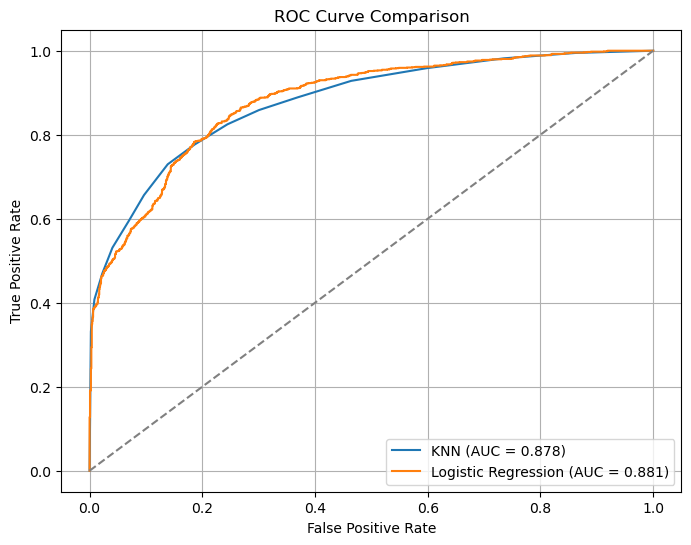

In [123]:
from sklearn.metrics import roc_auc_score, roc_curve, auc
import matplotlib.pyplot as plt

y_pred_knn_proba = best_knn_model.predict_proba(X_test)[:, 1]  
y_pred_lr_proba =  best_lr_model.predict_proba(X_test)[:, 1]  

roc_auc_knn = roc_auc_score(y_test, y_pred_knn_proba)
roc_auc_lr = roc_auc_score(y_test, y_pred_lr_proba)

print(f"ROC AUC for KNN: {roc_auc_knn:.3f}")
print(f"ROC AUC for Logistic Regression: {roc_auc_lr:.3f}")

fpr_knn, tpr_knn, _ = roc_curve(y_test, y_pred_knn_proba)
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_pred_lr_proba)

plt.figure(figsize=(8, 6))
plt.plot(fpr_knn, tpr_knn, label=f'KNN (AUC = {roc_auc_knn:.3f})')
plt.plot(fpr_lr, tpr_lr, label=f'Logistic Regression (AUC = {roc_auc_lr:.3f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Random guessing line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend()
plt.grid(True)
plt.show()

#### Discussion

From the results above we can see that when comparing tuned versions of the logistic regression and KNN models, logistic regression outperforms KNN in all the performance metrics except precision. 

In [124]:
best_model = best_lr_model

## Part B

Scenario 1: Both False Negatives (FN) and False Positives (FP) are costly
In this scenario, GTI wants a balanced approach that minimizes both FN and FP.

Goal: Find a threshold that achieves a good balance between precision and recall.

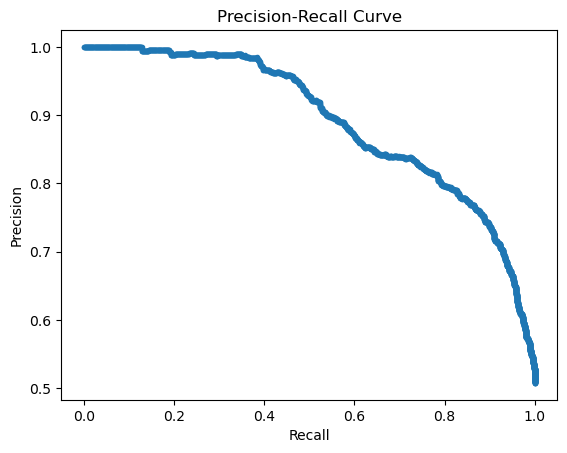

In [125]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

# Predict probabilities for the test set
y_scores = best_model.predict_proba(X_test)[:, 1]
precision, recall, thresholds = precision_recall_curve(y_test, y_scores)

plt.plot(recall, precision, marker='.')
plt.title('Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()

In [127]:
# Chat GPT used in this cell

# Create a DataFrame 
pr_curve_df = pd.DataFrame({
    'Threshold': thresholds.tolist() + [1.0],  # Add 1.0 for completeness
    'Precision': precision,
    'Recall': recall
})

pr_curve_df

,Threshold,Precision,Recall
0,2.369075e-12,0.507669,1.000000
1,1.341609e-11,0.507863,1.000000
2,1.578684e-11,0.508058,1.000000
3,1.811532e-11,0.508253,1.000000
4,6.141460e-09,0.508449,1.000000
...,...,...,...
2596,9.993443e-01,1.000000,0.003021
2597,9.996756e-01,1.000000,0.002266
2598,9.998103e-01,1.000000,0.001511
2599,9.999882e-01,1.000000,0.000755


Caclulate the threshold for maximising precision recall tradeoff

In [137]:
pr_curve_df['Precision_Recall_Product'] = pr_curve_df['Precision'] * pr_curve_df['Recall']

max_precision_recall_row = pr_curve_df.loc[pr_curve_df['Precision_Recall_Product'].idxmax()]

max_precision_recall_threshold = max_precision_recall_row['Threshold']
print(f"Threshold for maximising prcesion and recall tradeoff = {max_precision_recall_threshold}")

0.3956735185389736

Scenario 2: False Negatives (FN) are more costly than False Positives (FP)
Here, GTI prioritizes minimizing False Negatives.

Goal: Adjust the threshold to achieve higher recall, even if it increases FP.

In [138]:
# Chat GPT used here
max_recall_row = pr_curve_df.loc[pr_curve_df['Recall'].idxmax()]

max_recall_threshold = max_recall_row['Threshold']
print(f"Threshold for maximising recall tradeoff = {max_recall_threshold}")

Threshold for maximising recall tradeoff = 2.3690748762959474e-12


Documentation

Part A: I chose Logistic Regression and K-Nearest Neighbors because they are simple, effective models for classification tasks. Logistic Regression works well for binary outcomes amd modeling probability. KNN, on the other hand, is non-parametric and relies on the proximity of data points, making it good for capturing local patterns without assuming a specific data distribution. Both models are versatile, easy to implement, and perform well on a wide range of datasets.


Part B: for part B scenario 1, to minimise false posatives and false negatives I multiplied the recall values and the precision values and took the threshold that corresponded to the largest product value. For part B scenario 2 the aim was to minimise false negatives, i.e. maximise recall, so I took the threshold that corresponded to the max recall value. 


